<a href="https://colab.research.google.com/github/yunigma/Kaldi-for-ASR-of-Swiss-German/blob/master/practicle_2/Practical2_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical 2 : Generative and Discriminative Models


In this practical, we will compare the Naïve Bayes Classifier (NBC) and Logistic Regression on several
datasets. As part of the practical you should read briefly the following paper:



**On Discriminative vs. Generative classifiers: A comparison of logistic regression
and naive Bayes**  
*Andrew Y. Ng and Michael I. Jordan*  
Advances in Neural Information Processing Systems (NIPS) 2001.

The paper is available on OLAT. 

You should read the Introduction and the Experiments sections. The goal of this practical is
to qualitatively reproduce some of the experimental results in this paper. You are strongly
encouraged to read the rest of the paper, which is rather short and straightforward to read,
though some of you may want to skip the formal proofs.

## Naïve Bayes Classifier (NBC)

You should implement a Naïve Bayes Classifier from scartch using NumPy. To keep your code tidy,
we recommend implementing it as a class. 
The classifier should be able to handle binary and continuous features. 
To earn the bonus points, the classifier should be able to handle categorical features as well. 
Suppose the data has 3
different features, the first being binary, the second being continuous and the third being categorical. Write an implementation that you can initialise as follows:

    nbc = NBC(feature_types=['b', 'r', 'c'])

Along the lines of classifiers provided in sklearn, you want to implement two more functions,
**fit** and **predict**. 
Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y \mid \pi) \cdot p(\mathbf{x} \mid y, \theta)$.
The **fit** function is to estimate all the parameters ($\theta$ and $\pi$) of the NBC, i.e., train the classifier. The **predict** function is to compute the probabilities that the new input belongs to all classes and
then return the class that has the largest probability, i.e., make the prediction.

    nbc.fit(X_train, y_train)
    ypredicted = nbc.predict(X_test)
    test_accuracy = np.mean(ypredicted == ytest)

Here we import the libraries. 

In [11]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10., 10.)

import pickle as cp
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter, defaultdict
import _pickle as cp
import pandas as pd
from abc import ABC, abstractmethod

from scipy.stats import norm, bernoulli, multinomial

ALPHA = 1 # for additive smoothing
VAR_ZERO = 1e-6
NUM_FEAT_MULTINARY = 2

In [13]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# warnings.filterwarnings("ignore", category=[DeprecationWarning, ConvergenceWarning])

### Class-conditional distributions

Before implementing NBC, we first implement the class-conditional distributions $p(\mathbf{x} \mid y, \theta)$. Your implementation should have two functions: **estimate** and **get_log_probability**. 

- The **estimate** function takes data as input and models the data using some distribution $p(x \mid \theta)$, where $\theta$ is the parameters of this distribution. The function estimates the parameters $\theta$ using maximum likelihood estimators (MLE). 
For example, in the case of continuous features, we use the Gaussian distribution to model the data. The estimate function will find the parameters $\mu$ and $\sigma$ for the Gaussian distribution with respect to the input data. 

- The **get_log_probability** function takes as input a new data point $x_{new}$ and returns the log of $p(x_{new} \mid \theta)$. For the Gaussian distribution, the function get_probability will return $\mathcal{N}(x_{new} \mid \mu, \sigma)$. 

For different types of features, you need to use different distributions.
You can import statistic libraries (e.g., `scipy.stats`) for the implementation of the distributions. 

- For **continuous features**: Use Gaussian distribution
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
- For **binary features**: Use Bernoulli distribution 
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bernoulli.html
- For **categorical features**: Use Multinoulli distribution (The multinoulli distribution is a special case of the multinomial distribution, where the number of trials is 1)
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multinomial.html



**Implementation Issues:**
- The probabilities can be very small. To avoid underflow issues, you should compute the log of the probabilities. Read more: (Mur) Chapter 3.5.3 / Lecture Notes
- The variance for Gaussian distributions should never be exactly 0, so in
case your calculated variance is 0, you may want to set it to a small value such as 1e − 6. This is to ensure that your code never encounters division by zero or
taking logarithms of 0 errors. 
For this practical, please set the small value to 1e-6.
- Laplace/Additive smoothing: You want to ensure that the estimates for the parameter for the Bernoulli and Multinoulli random variables is never exactly 0 or 1. For this reason you should consider using Laplace smoothing (https://en.wikipedia.org/wiki/Additive_smoothing).
For this practical, please set alpha to 1.
- We will check the correctness of your implementation using the tests below.
- For simplicity, you can assume the data values for binary features are integers from {0,1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.
- Fell free to add auxiliary functions or change the parameters of the functions. If you change the parameters of the functions, make sure you change the tests accordingly, so we can test your code.


In [16]:
def Laplace_smoothing(count, N, num_of_categories):
  return (count + ALPHA) / (N + ALPHA * num_of_categories)


class NBCFeatureParam(ABC):
    @abstractmethod
    def get_log_probability(self, X_new):
        pass


class NBCFeatureParamDummyZero(NBCFeatureParam):
    def get_log_probability(self, X_new):
        return VAR_ZERO * VAR_ZERO


# Distribution for continuous features
class ContFeatureParam:
    def __init__(self):
        self.mean = np.array
        self.sd = np.array

    def estimate(self, X):
        # TODO: Estimate the parameters for the Gaussian distribution 
        # so that it best describes the input data X
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        self.mean = np.mean(X, axis=0)
        self.sd = np.std(X, axis=0)
        self.sd = np.array(self.sd)
        self.sd[self.sd == 0.0] = VAR_ZERO
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

    def get_log_probability(self, X_new):
        # TODO: return the log of the density values for the input values X_new
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        return norm.logpdf(X_new, self.mean, self.sd)
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################


# Distribution for binary features
class BinFeatureParam:
    def __init__(self):
        self.theta = 0.0

    def estimate(self, X):
        # TODO: Estimate the parameters for the Bernoulli distribution 
        # so that it best describes the input data X
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        X_smooth = np.append(X, [0, 1] * ALPHA)
        probs = X_smooth[np.where(X_smooth == 1)].size / X_smooth.size
        self.theta, var = bernoulli.stats(probs)
        return self.theta
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

    def get_log_probability(self, X_new):
        # TODO: return the log of the probability values for the input values X_new
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        return bernoulli.logpmf(X_new, self.theta)
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################


# Distribution for categorical features
class CatFeatureParam:
    
    # we need to know the number of categories for the categorical feature
    def __init__(self, num_of_categories):
        self._num_of_categories = num_of_categories
        self.theta = []
    
    def estimate(self, X):
        # TODO: Estimate the parameters for the Multinoulli distribution 
        # so that it best describes the input data X
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        counts = Counter(X)
        for k in range(self._num_of_categories):
          self.theta.append(Laplace_smoothing(counts[k], X.size, self._num_of_categories))
        return self.theta
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################
        
    def get_log_probability(self, X_new):
        # TODO: return the log of the probability values for the input values X_new
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        log_prob_values = []
        for k in X_new:
          data_point = np.zeros(self._num_of_categories)
          data_point[k] = 1
          log_prob_values.append(multinomial.logpmf(data_point, n=1,
                                                    p=self.theta))
        return log_prob_values
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

**Tests:**
    
We will use the code below to test the correctness of your code.

In [17]:
# continuous features

X = np.array([2.70508547,2.10499698,1.76019132,3.42016431,3.47037973,3.67435061,1.84749286,4.3388506,2.27818252,4.65165335])

param = ContFeatureParam()
param.estimate(X)
probs = param.get_log_probability(np.array([0,1,2,3]))
print(probs)

[-5.64670664 -3.02757918 -1.44567455 -0.90099277]


In [18]:
# binary features

X = np.array([0,0,1,1,0,1,0,1,1,1])

param = BinFeatureParam()
param.estimate(X)
probs = param.get_log_probability(np.array([0,1]))
print(probs)

[-0.87546874 -0.5389965 ]


In [19]:
# categorical features (bonus task)

X = np.array([0,6,5,4,0,6,6,4,1,1,2,3,8,8,1,6,4,9,0,2,2,3,8,0,2])

param = CatFeatureParam(num_of_categories=10)
param.estimate(X)
probs = param.get_log_probability(np.array([0,1,2,3,4,5,6,7,8,9]))
print(probs)

[array(-1.94591015), array(-2.1690537), array(-1.94591015), array(-2.45673577), array(-2.1690537), array(-2.86220088), array(-1.94591015), array(-3.55534806), array(-2.1690537), array(-2.86220088)]


### Implement NBC

We are now ready to implement NBC. We follow the structure of models in scikit-learn. We implement NBC as a class with functions **init**, **fit** and **predict**.
The **init** function takes as input the types of features and initialise the classifier. The **fit** function takes the training data as input and estimates the parameters. The **predict** function predicts the label for the input data. 

**Implementation Issues:**
- You should use matrix operations rather than loops. In general, loops over classes or features are OK, but loops over the rows of data are not a good idea.
- The probabilities can be very small. To avoid underflow issues, you should do the calculations in log space. Read more: (Mur) Chapter 3.5.3 / Lecture Note
- For simplicity, you can assume the data values for binary features are integers from {0, 1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.
- Fell free to add auxiliary functions or change the parameters of the functions. If you change the parameters of the functions, make sure you change the tests accordingly, so we can test your code.

In [20]:
# Your task is to implement the three functions of NBC. 
class NBC:
    # Inputs:
    #   feature_types: the array of the types of the features, e.g., feature_types=['r', 'b', 'c']
    def __init__(self, feature_types=np.array):
        # TODO: 
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        self._feature_types = feature_types
        self._n_classes = int
        self._n_feats = int
        self.class_feat_params = []
        self._prior = {}
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

    def get_log_cond_prob(self, cl, x_test):
        feature_cond_probs = []
        for feat in range(self._n_feats):
          feature_cond_prob = self.class_feat_params[cl][feat].get_log_probability(x_test[feat])
          feature_cond_probs.append(feature_cond_prob)
        return feature_cond_probs

    def get_posterior(self, x_test):
        posteriors = []
        for cl in range(self._n_classes):
          conditional = np.sum(self.get_log_cond_prob(cl, x_test))
          posterior = np.log(self._prior[cl]) + conditional
          posteriors.append(posterior)
        return np.argmax(posteriors)

    # The function uses the input data to estimate all the parameters of the NBC
    def fit(self, X, y):
        # TODO: 
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        continuous_feats_ids = np.squeeze(np.argwhere(self._feature_types == 'r'), 1)
        binary_feats_ids = np.squeeze(np.argwhere(self._feature_types == 'b'), 1)
        categorical_feats_ids = np.squeeze(np.argwhere(self._feature_types == 'c'), 1)
        X_continuous_feats = X[:, continuous_feats_ids]
        X_binary_feats = X[:, binary_feats_ids]
        X_categorical_feats = X[:, categorical_feats_ids]

        self._n_classes = np.unique(y).size
        data_size = X.shape[0]
        self._n_feats = X.shape[1]

        for cl in range(self._n_classes):
            class_ids = np.squeeze(np.argwhere(y == cl))
            class_params = np.repeat(NBCFeatureParamDummyZero(), self._n_feats)
            
            for i, feat in enumerate(range(self._n_feats)):
              if continuous_feats_ids != []:
                params_contin = ContFeatureParam()
                params_contin.estimate(X_continuous_feats[class_ids, i])
                class_params[i] = params_contin

              if binary_feats_ids != []:
                params_bin = BinFeatureParam()
                params_bin.estimate(X_binary_feats[class_ids, i])
                class_params[i] = params_bin

              if categorical_feats_ids != []:
                params_cat = CatFeatureParam()
                params_cat.estimate(X_binary_feats[class_ids, i])
                class_params[i] = params_cat
              
            self.class_feat_params.append(list(class_params))

        self._prior = {k: Laplace_smoothing(v, data_size,
                                            self._n_classes) for k, v in Counter(y).items()}

        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################
                
                
    # The function takes the data X as input, and predicts the class for the data
    def predict(self, X_test):
        # TODO: 
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        #preds = np.apply_along_axis(self.get_posterior, 1, X_test)
        preds = [self.get_posterior(f) for f in X_test]
        return preds
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

    def accuracy(self, y_test, y_pred):
        accuracy = np.sum(y_test == y_pred) / len(y_test)
        return accuracy

**Tests**

We will use the code below to check your code.

In [22]:
# CONTINUOUS
# All features of the iris dataset are continuous.
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']

N, D = X.shape
shuffle = np.random.permutation(N)
Ntrain = int(0.8 * N)
Xtrain = X[shuffle[:Ntrain]]
ytrain = y[shuffle[:Ntrain]]
Xtest = X[shuffle[Ntrain:]]
ytest = y[shuffle[Ntrain:]]

nbc_iris = NBC(feature_types=np.array(['r', 'r', 'r', 'r']))
nbc_iris.fit(Xtrain, ytrain)
yhat = nbc_iris.predict(Xtest)
print(ytest)
test_accuracy = np.mean(yhat == ytest)
print("Accuracy:", test_accuracy) # should be larger than 90%
print(yhat)

[1 1 0 1 2 2 2 2 1 1 0 2 2 2 0 2 0 2 1 0 2 2 0 1 1 0 0 2 0 0]
Accuracy: 0.9666666666666667
[1, 1, 0, 1, 2, 2, 2, 2, 1, 1, 0, 1, 2, 2, 0, 2, 0, 2, 1, 0, 2, 2, 0, 1, 1, 0, 0, 2, 0, 0]


In [24]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [25]:
# BINARY
# All features of this dataset are binary
# data = pd.read_csv('./datasets/binary_test.csv', header=None)
data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/binary_test.csv', header=None)
data = data.to_numpy()

X = data[:,1:]
y = data[:,0]

N, D = X.shape
shuffle = np.random.permutation(N)
Ntrain = int(0.8 * N)
Xtrain = X[shuffle[:Ntrain]]
ytrain = y[shuffle[:Ntrain]]
Xtest = X[shuffle[Ntrain:]]
ytest = y[shuffle[Ntrain:]]
#Xtrain = X[:Ntrain]
#ytrain = y[:Ntrain]
#Xtest = X[Ntrain:]
#ytest = y[Ntrain:]

In [26]:
nbc = NBC(feature_types=np.array(['b'] * 16))
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 85%
print(yhat)

Accuracy: 0.8723404255319149
[0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0]


In [27]:
# CATEGORIAL
# All features of this dataset are categorical (bonus task)
# data = pd.read_csv('./datasets/categorical_test.csv', header=None)
data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/categorical_test.csv', header=None)
data = data.to_numpy()

X = data[:,:-1]
y = data[:,-1]

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]

In [ ]:
nbc = NBC(feature_types=np.array(['c'] * 9))
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 65%
print(yhat)

## Logistic Regression

For logistic regression, you should use the implementation in scikit-learn. Add the following
line to import the LR model.

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

RUN_TIMES = 200

Check the scikit-learn documentation for the Logistic Regression model:
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression


## Comparing NBC and LR

### Experiments

The experiment is to compare the classification error of the NBC and LR trained on increasingly larger training datasets. 
Since the datasets are so small, you should do this multiple times and
average the classification error. One run should look as follows:
- Shuffle the data, put 20% aside for testing.
    
    ```N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    
    ```  


- Train the classifiers with increasingly more data. For example, we can train classifiers with 10%, 20%, ..., 100% of the training data. For each case store the classification errors on the test set of the classifiers.

You may want to repeat this with at least 200 random permutations (possibly as large as 1000)
to average out the test error across the runs. In the end, you will get average test errors as a function of the size of the training data. 
We have written for you the function for making the plots for the experiments. 

In [29]:
# inputs:
#   nbc: Naive Bayes Classifier
#   lr: Logistic Regression Classifier
#   X, y: data
#   num_runs: we need repeat num_runs times and store average results
#   num_splits: we want to compare the two models on increasingly larger training sets.
#               num_splits defines the number of increasing steps. 
# outputs:
#   the arrays of the test errors across the runs of the two classifiers 
def compareNBCvsLR(nbc, lr, X, y, num_runs=10, num_splits=10):
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    tst_errs_nbc = np.zeros(num_splits)
    tst_errs_lr = np.zeros(num_splits)

    N, D = X.shape
    # Ntrain = int(0.8 * N)

    div = 1 / num_splits
    for j in range(0, num_splits):
        nbc_total = 0
        lr_total = 0
        fraction = div * (j + 1)
        train_size = int(0.8 * N * fraction)
        for i in range(0, num_runs):
            '''shuffler = np.random.permutation(N)
            Xtrain = X[shuffler[:Ntrain]]
            ytrain = y[shuffler[:Ntrain]]
            Xtest = X[shuffler[Ntrain:]]
            ytest = y[shuffler[Ntrain:]]'''
            Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, train_size=train_size, stratify=y)
            Xtrain = Xtrain[:train_size]

            lr.fit(Xtrain, ytrain)
            nbc.fit(Xtrain, ytrain)
            yhat = nbc.predict(Xtest)
            nbc_score = np.mean(yhat == ytest)
            lr_score = lr.score(Xtest, ytest)
            nbc_total += nbc_score
            lr_total += lr_score
        lr_avg = lr_total / num_runs 
        nbc_avg = nbc_total / num_runs
        tst_errs_lr[j] = 1 - lr_avg    
        tst_errs_nbc[j] = 1 - nbc_avg
    
    return tst_errs_nbc, tst_errs_lr
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################

In [30]:
def makePlot(nbc_perf, lr_perf, title=None, num_splits=10):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.tick_params(axis='both', labelsize=20)

    ax.set_xlabel('Percent of training data used', fontsize=20)
    ax.set_ylabel('Classification Error', fontsize=20)
    if title is not None: ax.set_title(title, fontsize=25)

    xaxis_scale = [(i + 1) * (100/num_splits) for i in range(num_splits)]
    plt.plot(xaxis_scale, nbc_perf, label='Naive Bayes')
    plt.plot(xaxis_scale, lr_perf, label='Logistic Regression', linestyle='dashed')
    
    ax.legend(loc='upper right', fontsize=20)

### Datasets

Tasks: For each dataset,
1. prepare the data for the two classifiers, e.g., handle missing values, handle text/categorical data, etc.
2. compare the two classifiers on the dataset and generate the plots
3. write a short report of how you prepare the data and your observations of the comparison 

**Dataset 1: Iris Dataset**

https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

In [ ]:
# Features: 4 continuous, 3 classes
# Preparation: No missing data, nothing to be cleaned

# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
from sklearn.datasets import load_iris
iris = load_iris()
iris_X, iris_y = iris['data'], iris['target']

n, D = iris_X.shape
feature_types = np.array(['r'] * D)
lr = LogisticRegression()
nb = NBC(feature_types=feature_types)

nbc_perf, lr_perf = compareNBCvsLR(nb, lr, iris_X, iris_y, RUN_TIMES, 10)
makePlot(nbc_perf, lr_perf, title="Iris")
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

**Dataset 2: Voting Dataset**

https://archive.ics.uci.edu/ml/datasets/congressional+voting+records

The logistic regression line meets the naive bayes line early in the plot. To see it clearer, you should use only 100 data points from the dataset for this experiment.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232 entries, 5 to 431
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   label                                   232 non-null    object
 1   handicapped-infants                     232 non-null    object
 2   water-project-cost-sharing              232 non-null    object
 3   adoption-of-the-budget-resolution       232 non-null    object
 4   physician-fee-freeze                    232 non-null    object
 5   el-salvador-aid                         232 non-null    object
 6   religious-groups-in-schools             232 non-null    object
 7   anti-satellite-test-ban                 232 non-null    object
 8   aid-to-nicaraguan-contras               232 non-null    object
 9   mx-missile                              232 non-null    object
 10  immigration                             232 non-null    object
 11  synfue

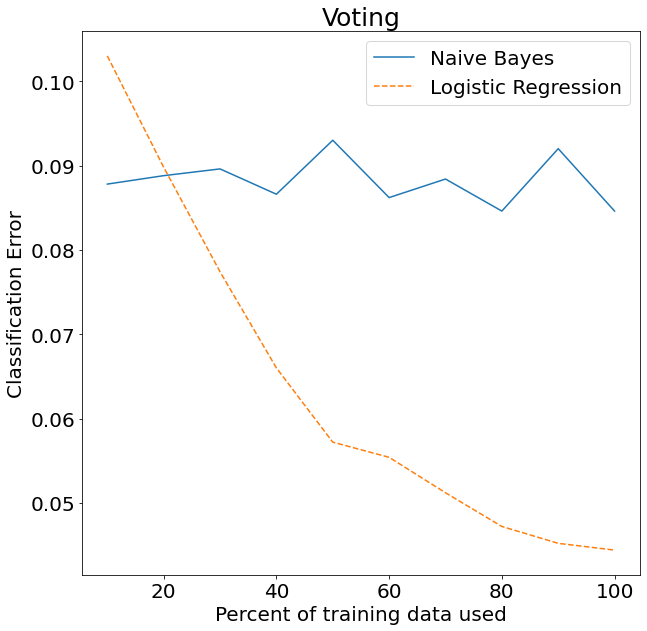

In [35]:
# Features: 16 binary features
# Preparation: This dataset has missing data. Since it does not make sense to fill binary data with a mean or median, we remove rows with missing data.
# Entries: 431, Cleaned: 232
# Classes: 2 classes (democratic, republican)

# load the dataset
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
#load dataset
#voting = pd.read_csv('./datasets/voting.csv')
voting = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/voting.csv')

#prep dataset: remove all rows with missing data
voting = voting.dropna()
voting.info()

#prep dataset: replace labels with numeric
#              split into x (features) and y (labels)
#              replace text labels and features with int

yes_no_to_bin = {"y": 1,
                "n": 0}
labels_to_bin = {"democrat": 1,
                 "republican": 0}
voting = voting.replace(yes_no_to_bin)
voting = voting.replace(labels_to_bin)

# Take 100 data points + 25 data points for test set
voting = voting[:125]

voting_y = np.array(voting['label'])
voting_X = voting.drop('label',axis=1).to_numpy()

n, D = voting_X.shape
feature_types = np.array(['r'] * D) 

# #train and test:
lr = LogisticRegression()
nb = NBC(feature_types=feature_types)

nbc_perf, lr_perf = compareNBCvsLR(nb, lr, voting_X, voting_y, RUN_TIMES, 10)
makePlot(nbc_perf, lr_perf, title="Voting")

###################################################
##### YOUR CODE ENDS HERE #########################
###################################################